In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [12]:
exp_id_list = ['df00f4d3-de71-4bb3-8d47-6ac9dcaac9fd']
r = readers.CollectionReader('agents', exp_filter=lambda exp_id: exp_id in exp_id_list)

  0%|          | 0/408 [00:00<?, ?it/s]


OSError: HDF5 error back trace

  File "H5F.c", line 509, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1400, in H5F__open
    unable to open file
  File "H5Fint.c", line 1615, in H5F_open
    unable to lock the file
  File "H5FD.c", line 1640, in H5FD_lock
    driver lock request failed
  File "H5FDsec2.c", line 941, in H5FD_sec2_lock
    unable to lock file, errno = 11, error message = 'Resource temporarily unavailable'

End of HDF5 error back trace

Unable to open/create file 'agents/df00f4d3-de71-4bb3-8d47-6ac9dcaac9fd/store.h5'

In [9]:
metadata = r.df('metadata')
opt = r.df('optimization')
nadv = r.df('normalized_advantage')
constraints = r.df('paper_constraints_train')
constraints_heldout = r.df('paper_constraints_heldout')

In [10]:
code_level_opts = {
      'clip_eps': [0.2, 1e8],
      'kl_penalty_coeff': [0.0, 0.3, 1, 3, 10],
      'kl_penalty_direction': ['old_to_new', 'new_to_old'],
      'clip_advantages': [2, 3, 1e8],
      'norm_rewards': ['none', 'returns'],
      'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [11]:
key_metadata = metadata[['exp_id', 'game', 'clip_eps', 'kl_penalty_coeff', 'kl_penalty_direction',
                         'clip_advantages', 'norm_rewards', 'anneal_lr']]

# Plot max rewards

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


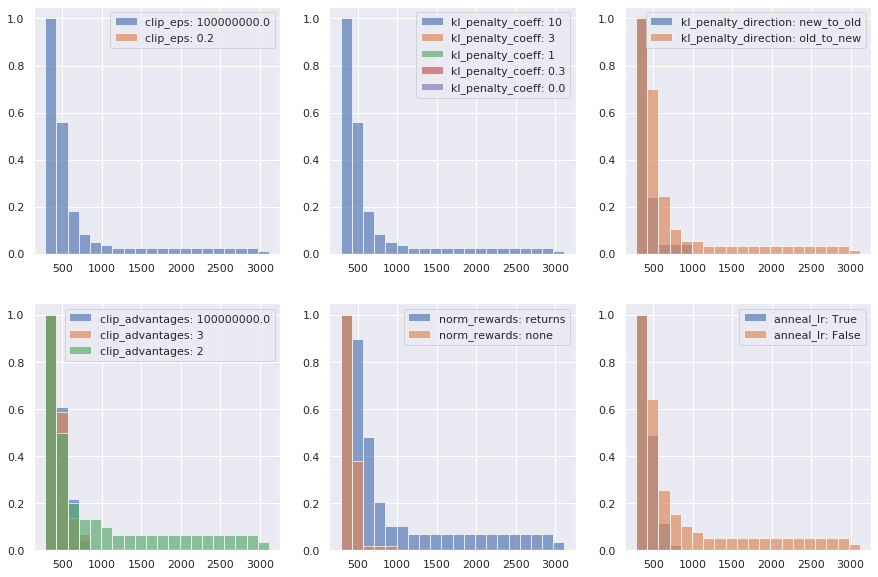

In [12]:
max_rewards = opt.groupby('exp_id').max()

# Histogram setup
_, bin_edges = np.histogram(max_rewards['mean_reward'].tolist(), NUM_BINS)
bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_ws = (bin_edges[1] - bin_edges[0])

# Plot setup
kwargs = {'width': bin_ws, 'alpha': 0.65}
fig, ax = plt.subplots(2, 3, figsize=(15,10))

for i, cl_opt in enumerate(code_level_opts):
    for b in reversed(code_level_opts[cl_opt]):
        exp_ids = set(metadata[metadata[cl_opt] == b]['exp_id'].tolist())
        filt = max_rewards[max_rewards.index.isin(exp_ids)]
        hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
        hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
        ax.flatten()[i].bar(bin_locs, hist, label=f"{cl_opt}: {b}", **kwargs)
    ax.flatten()[i].legend()
plt.show()

In [14]:
for i, cl_opt in enumerate(code_level_opts):
    print(cl_opt)
    for b in reversed(code_level_opts[cl_opt]):
        exp_ids = set(metadata[metadata[cl_opt] == b]['exp_id'].tolist())
        filt = max_rewards[max_rewards.index.isin(exp_ids)]
        print(b, filt['mean_reward'].count(), filt['mean_reward'].mean())

clip_eps
100000000.0 82 534.9633224091752
0.2 0 nan
kl_penalty_coeff
10 82 534.9633224091752
3 0 nan
1 0 nan
0.3 0 nan
0.0 0 nan
kl_penalty_direction
new_to_old 25 413.36246418303926
old_to_new 57 588.2970321574807
clip_advantages
100000000.0 23 476.7743855633538
3 29 465.6561809813657
2 30 646.5717440378543
norm_rewards
returns 29 756.7086889157067
none 53 413.630952056545
anneal_lr
True 43 442.272160696903
False 39 637.1612699380909


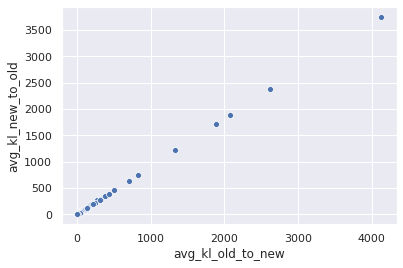

In [15]:
sns.scatterplot(constraints.avg_kl_old_to_new, constraints.avg_kl_new_to_old)

In [18]:
constraints[constraints.avg_kl_new_to_old.isnull()]

,avg_kl_old_to_new,avg_kl_new_to_old,max_ratio,opt_step,exp_id
28,NaN,NaN,NaN,280,8312b8c4-6834-4ddf-a648-8f46d7e05d85
22,NaN,NaN,NaN,220,b8542139-a4b6-48ae-aeae-24831e2d908f


In [21]:
constraints[constraints.exp_id == 'b8542139-a4b6-48ae-aeae-24831e2d908f']

,avg_kl_old_to_new,avg_kl_new_to_old,max_ratio,opt_step,exp_id
0,0.042069,0.041202,3.975292e+00,0,b8542139-a4b6-48ae-aeae-24831e2d908f
1,0.018747,0.018247,2.102965e+00,10,b8542139-a4b6-48ae-aeae-24831e2d908f
2,0.022868,0.022229,2.180505e+00,20,b8542139-a4b6-48ae-aeae-24831e2d908f
3,0.017163,0.016652,2.213277e+00,30,b8542139-a4b6-48ae-aeae-24831e2d908f
4,0.023640,0.022831,1.994500e+00,40,b8542139-a4b6-48ae-aeae-24831e2d908f
5,0.026400,0.025253,2.027783e+00,50,b8542139-a4b6-48ae-aeae-24831e2d908f
6,0.028864,0.027352,1.906243e+00,60,b8542139-a4b6-48ae-aeae-24831e2d908f
7,0.014243,0.013750,1.405241e+00,70,b8542139-a4b6-48ae-aeae-24831e2d908f
8,0.082587,0.065602,2.513209e+00,80,b8542139-a4b6-48ae-aeae-24831e2d908f
9,0.364145,-0.270590,2.007469e+00,90,b8542139-a4b6-48ae-aeae-24831e2d908f


In [20]:
opt.mean_std.min()

3.014889671248966e-08

In [29]:
opt[opt.mean_std.isnull()].merge(key_metadata, on='exp_id')

,mean_reward,final_value_loss,mean_std,exp_id,game,clip_eps,kl_penalty_coeff,kl_penalty_direction,clip_advantages,norm_rewards,anneal_lr
0,203.803056,63.582630,NaN,ef3b1899-cc29-4d58-8fa7-d5caf01f0207,Walker2d-v2,100000000.0,10,new_to_old,2.0,none,True
1,259.085948,92.103241,NaN,8312b8c4-6834-4ddf-a648-8f46d7e05d85,Walker2d-v2,100000000.0,10,new_to_old,2.0,none,True
2,340.758283,132.534882,NaN,7a3ed991-c3b7-42ed-bdbc-509707b052e7,Walker2d-v2,100000000.0,10,new_to_old,2.0,none,True
3,235.312804,59.157978,NaN,ebceef90-7578-4061-b005-69bc72cce6f9,Walker2d-v2,100000000.0,10,new_to_old,2.0,none,True
4,342.828927,136.127518,NaN,ce54ad2f-8da2-4cae-95af-9eb1f17788b7,Walker2d-v2,100000000.0,10,new_to_old,2.0,none,True
5,246.949143,61.802807,NaN,a9783a2e-5b01-455c-aca8-67d6e5ad4646,Walker2d-v2,100000000.0,10,new_to_old,3.0,none,True
6,215.833350,14.120076,NaN,eee35168-023a-4654-a43c-196f98ffd86e,Walker2d-v2,100000000.0,10,new_to_old,3.0,none,True
7,263.380050,110.584221,NaN,fca035c5-e3a5-4020-8218-860f686fc11a,Walker2d-v2,100000000.0,10,new_to_old,3.0,none,True
8,323.694130,145.303864,NaN,b93c1c01-0445-457e-99f2-17b46381711c,Walker2d-v2,100000000.0,10,new_to_old,3.0,none,True
9,297.171603,88.238434,NaN,2f282498-d86b-4a81-85f2-37e8d953fa22,Walker2d-v2,100000000.0,10,new_to_old,100000000.0,none,True


In [28]:
opt[opt.exp_id == 'ef3b1899-cc29-4d58-8fa7-d5caf01f0207']

,mean_reward,final_value_loss,mean_std,exp_id
0,-1.471191,13.223359,9.757009e-01,ef3b1899-cc29-4d58-8fa7-d5caf01f0207
1,5.845686,16.999489,9.532725e-01,ef3b1899-cc29-4d58-8fa7-d5caf01f0207
2,15.467989,24.726418,9.350398e-01,ef3b1899-cc29-4d58-8fa7-d5caf01f0207
3,63.817007,109.742813,9.221766e-01,ef3b1899-cc29-4d58-8fa7-d5caf01f0207
4,78.713474,219.780136,9.090853e-01,ef3b1899-cc29-4d58-8fa7-d5caf01f0207
...,...,...,...,...
265,206.644650,54.635300,3.520631e-08,ef3b1899-cc29-4d58-8fa7-d5caf01f0207
266,202.564789,60.014244,3.367203e-08,ef3b1899-cc29-4d58-8fa7-d5caf01f0207
267,213.205475,75.187210,3.220468e-08,ef3b1899-cc29-4d58-8fa7-d5caf01f0207
268,196.460278,54.452820,3.080077e-08,ef3b1899-cc29-4d58-8fa7-d5caf01f0207


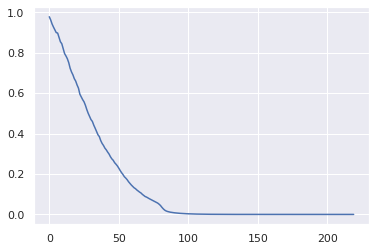

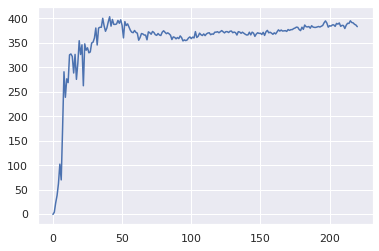

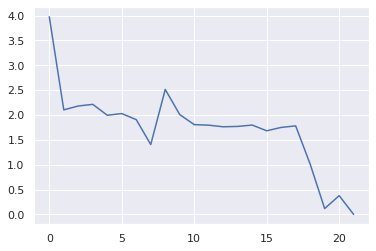

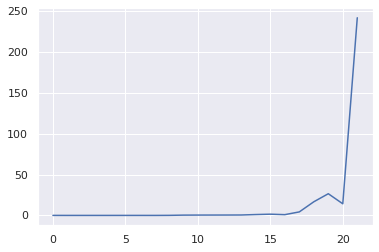

In [22]:
tmp = opt[opt.exp_id == 'b8542139-a4b6-48ae-aeae-24831e2d908f']
plt.plot(tmp.mean_std)
plt.show()
plt.plot(tmp.mean_reward)
plt.show()
tmp = constraints[constraints.exp_id == 'b8542139-a4b6-48ae-aeae-24831e2d908f']
plt.plot(tmp.max_ratio)
plt.show()
plt.plot(tmp.avg_kl_old_to_new)
plt.show()

In [54]:
constraints[constraints.avg_kl_old_to_new > 10000]

,avg_kl_old_to_new,avg_kl_new_to_old,max_ratio,opt_step,exp_id
25,21454.496094,21397.339844,0.000000e+00,250,10b19ba4-47a9-4ff9-9be6-254471d23a0e
31,21794.802734,21643.414062,0.000000e+00,310,10b19ba4-47a9-4ff9-9be6-254471d23a0e
32,14159.344727,14031.750000,0.000000e+00,320,10b19ba4-47a9-4ff9-9be6-254471d23a0e
37,66486.453125,66665.695312,0.000000e+00,370,10b19ba4-47a9-4ff9-9be6-254471d23a0e
38,28327.593750,28208.550781,0.000000e+00,380,10b19ba4-47a9-4ff9-9be6-254471d23a0e
...,...,...,...,...,...
35,27931.982422,27854.939453,3.521837e-17,350,91743ad3-dcc7-4935-a5a4-304755e93d5f
45,10708.198242,10648.035156,3.788038e-30,450,91743ad3-dcc7-4935-a5a4-304755e93d5f
36,12051.939453,12045.361328,0.000000e+00,360,7bdc2707-6c5a-4951-a346-26b2facaf67d
41,21032.343750,21069.712891,1.821566e-24,410,7bdc2707-6c5a-4951-a346-26b2facaf67d


In [46]:
from scipy.stats.stats import pearsonr   
pearsonr(constraints.avg_kl_old_to_new.dropna(), constraints.avg_kl_new_to_old.dropna())

(0.9999921627645318, 0.0)

In [56]:
key_metadata[metadata.exp_id == '10b19ba4-47a9-4ff9-9be6-254471d23a0e']

,exp_id,game,clip_eps,kl_penalty_coeff,kl_penalty_direction,clip_advantages,norm_rewards,anneal_lr
0,10b19ba4-47a9-4ff9-9be6-254471d23a0e,Walker2d-v2,0.2,0.0,old_to_new,2.0,none,False


In [55]:
constraints[constraints['exp_id'] == '10b19ba4-47a9-4ff9-9be6-254471d23a0e']

,avg_kl_old_to_new,avg_kl_new_to_old,max_ratio,opt_step,exp_id
0,0.017864,0.017863,1.863369e+00,0,10b19ba4-47a9-4ff9-9be6-254471d23a0e
1,0.014469,0.014282,2.042114e+00,10,10b19ba4-47a9-4ff9-9be6-254471d23a0e
2,0.011031,0.011004,1.781554e+00,20,10b19ba4-47a9-4ff9-9be6-254471d23a0e
3,0.016460,0.016150,1.985707e+00,30,10b19ba4-47a9-4ff9-9be6-254471d23a0e
4,0.024990,0.024720,1.995406e+00,40,10b19ba4-47a9-4ff9-9be6-254471d23a0e
5,0.049698,0.048512,1.995813e+00,50,10b19ba4-47a9-4ff9-9be6-254471d23a0e
6,0.563423,0.537051,5.081413e+00,60,10b19ba4-47a9-4ff9-9be6-254471d23a0e
7,0.547046,0.518390,2.783678e+00,70,10b19ba4-47a9-4ff9-9be6-254471d23a0e
8,1.095960,1.039261,1.896763e+00,80,10b19ba4-47a9-4ff9-9be6-254471d23a0e
9,1.080727,1.021425,1.905859e+00,90,10b19ba4-47a9-4ff9-9be6-254471d23a0e


In [20]:
max_rewards

,mean_reward,final_value_loss,mean_std
exp_id,,,
026caf7b-697b-43c9-87b1-8e646b46ee80,3091.726190,0.581443,0.989631
03f8f806-93dc-412e-a3b5-f0f033edbd5a,2776.820299,0.670724,0.993294
0453f336-5c68-401c-ba77-6e0c784d4329,998.100589,931.091614,1.002480
065abd2f-fb94-4391-b272-8cf18de6e8c6,1327.725381,0.586935,0.991911
06aa16d2-13b1-427c-9c13-b37b5e05337e,2909.735025,0.291269,0.994450
...,...,...,...
f962171b-569a-4d21-b677-d2359cf48650,2142.443377,0.293120,0.993816
f9c88001-d0af-4a78-bd02-487f139551c9,738.905713,0.394644,0.992167
fc4f0ccf-7f24-4417-bee1-51c77ecf4b2d,3217.999112,0.660020,0.996559


# Code for extracting histogram and scalars

In [7]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def extract_nadv(exp_ids):
    aggregate_approx_nadv = []
    for exp_id in exp_ids:
        path = 'agents/%s/tensorboard' % exp_id
        event_acc = EventAccumulator(path, size_guidance={
            'histograms': 500,
        })
        event_acc.Reload()
        histograms = event_acc.Histograms('normalized_advantages')
        for h in histograms:
            bucket_limit = np.array(h.histogram_value.bucket_limit)
            bucket_counts = np.array(h.histogram_value.bucket).astype(np.int)
            aggregate_approx_nadv.append(np.repeat(bucket_limit, bucket_counts))
    return np.array(aggregate_approx_nadv)

def show_histogram(exp_ids, figure_title=''):
    aggregate_approx_nadv = extract_nadv(exp_ids)
    sns.distplot(aggregate_approx_nadv.flatten())
    plt.title(figure_title)
    plt.show()
    
def extract_logZ(exp_ids, eta=0.1):
    aggregate_approx_nadv = extract_nadv(exp_ids)
    return np.log(np.mean(np.exp(eta * aggregate_approx_nadv)) + 1e-10)
    
def extract_scalar(exp_ids, scalar_name, n_records=50):
    scalars = np.zeros((len(exp_ids), n_records))
    for i, exp_id in enumerate(exp_ids):
        path = 'agents/%s/tensorboard' % exp_id
        event_acc = EventAccumulator(path, size_guidance={
            'scalars': 500,
        })
        event_acc.Reload()
        scalars_this_exp = np.array(event_acc.Scalars(scalar_name))[:, 2]
        scalars[i, :len(scalars_this_exp)] = scalars_this_exp
    return scalars

def avg_kurtosis(exp_ids):
    return np.mean(extract_scalar(exp_ids, 'normalized_advantage/kurtosis'))

def max_normalized_adv(exp_ids):
    return np.max(extract_scalar(exp_ids, 'normalized_advantage/max'))

def min_normalized_adv(exp_ids):
    return np.min(extract_scalar(exp_ids, 'normalized_advantage/min'))

# Advantage Distribution, aggregated

In [8]:
exp_id_lookup = key_metadata.groupby(
    ['game', 'clip_eps', 'value_clipping', 'norm_rewards', 'anneal_lr'])['exp_id'].apply(list)
exp_id_lookup = exp_id_lookup.reset_index()

In [9]:
exp_id_lookup.tail(1)

,game,clip_eps,value_clipping,norm_rewards,anneal_lr,exp_id
15,Walker2d-v2,1.000000e+10,True,returns,True,"[ac6ad1eb-e374-435d-968b-e78ce18b059c, fc11286..."


In [42]:
#exp_id_lookup['avg_kurtosis'] = exp_id_lookup.exp_id.apply(avg_kurtosis)
#exp_id_lookup['logZ'] = exp_id_lookup.exp_id.apply(extract_logZ)
#exp_id_lookup['max_nadv'] = exp_id_lookup.exp_id.apply(max_normalized_adv)
#exp_id_lookup['min_nadv'] = exp_id_lookup.exp_id.apply(min_normalized_adv)
#exp_id_lookup['max_ratio_pred'] = (0.1 * exp_id_lookup.max_nadv).apply(np.exp) / exp_id_lookup['logZ']
#exp_id_lookup['min_ratio_pred'] = (0.1 * exp_id_lookup.min_nadv).apply(np.exp) / exp_id_lookup['logZ']

In [43]:
exp_id_lookup[['clip_eps', 'value_clipping', 'norm_rewards', 'anneal_lr', 'logZ', 'max_ratio_pred', 'min_ratio_pred']].head(2)

,clip_eps,value_clipping,norm_rewards,anneal_lr,logZ,max_ratio_pred,min_ratio_pred
0,0.2,False,none,False,0.008586,292.426181,35.819251
1,0.2,False,none,True,0.008572,307.686403,39.332291


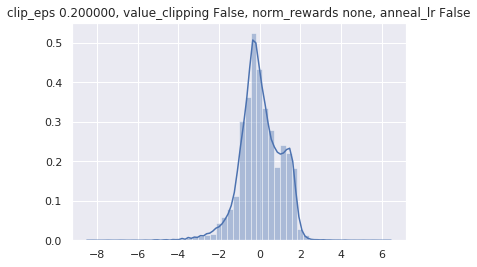

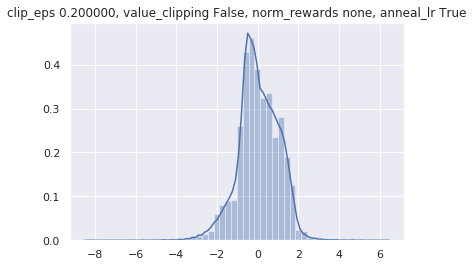

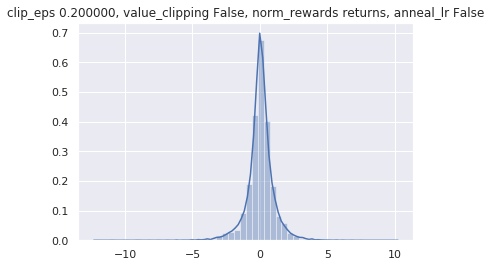

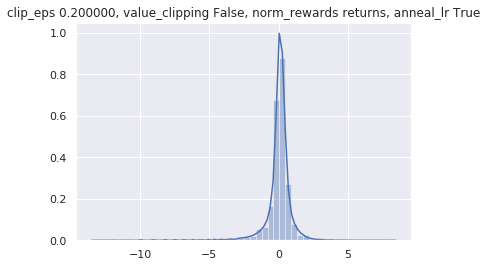

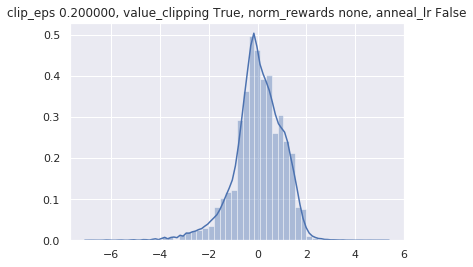

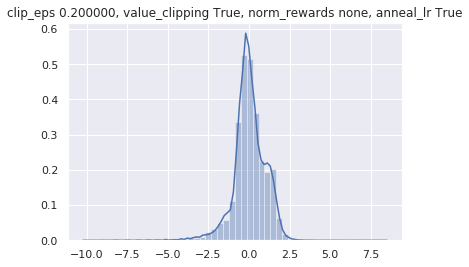

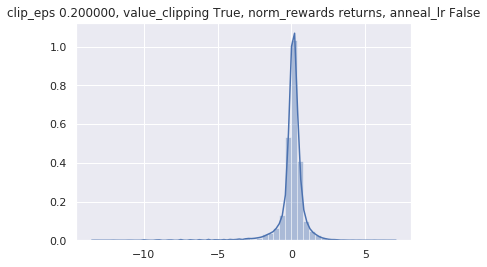

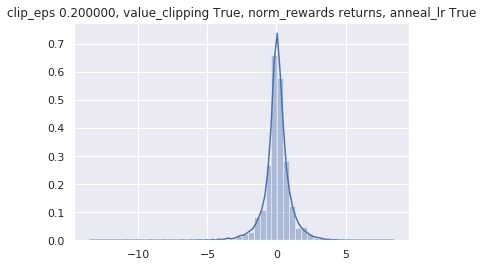

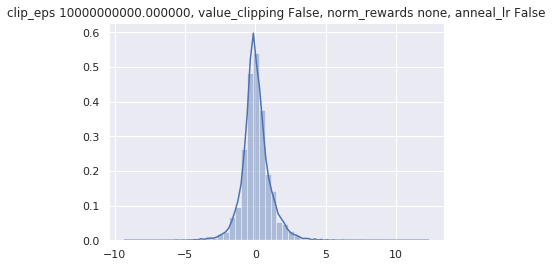

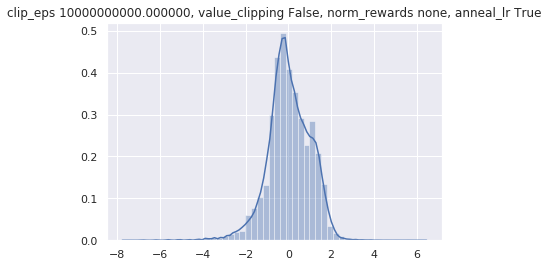

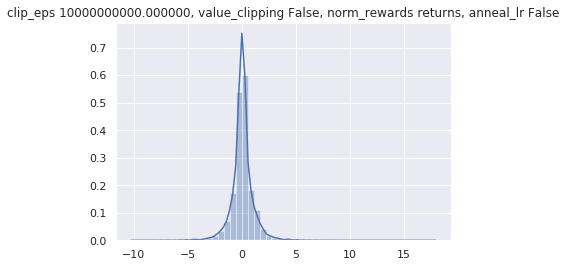

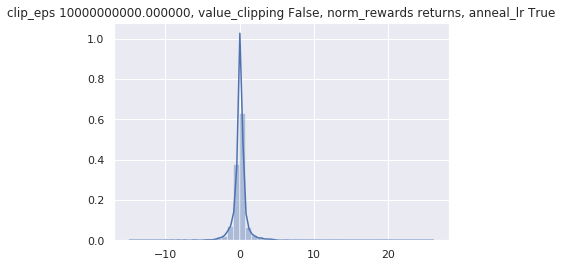

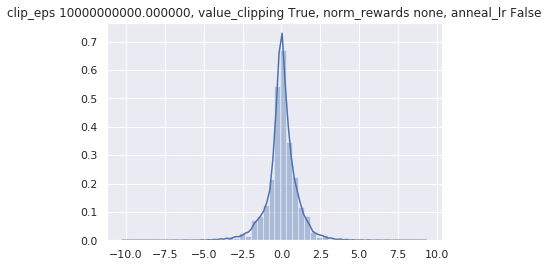

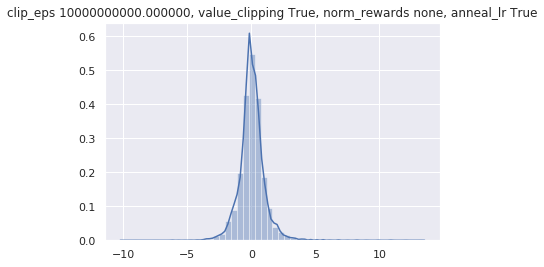

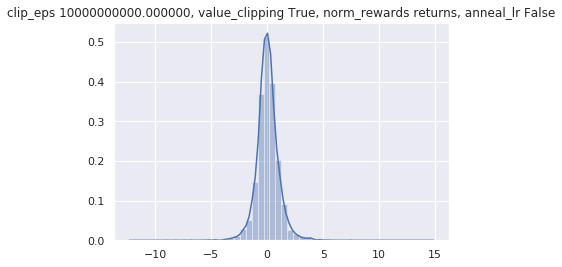

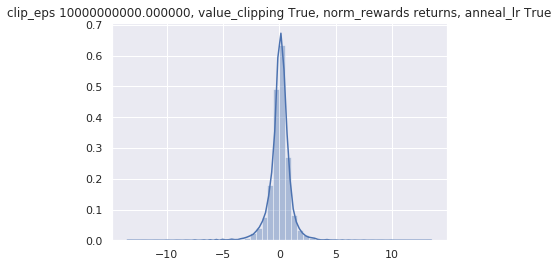

In [49]:
for i, row in exp_id_lookup.iterrows():
    title = "clip_eps %f, value_clipping %s, norm_rewards %s, anneal_lr %s" % (
        row.clip_eps, row.value_clipping, row.norm_rewards, row.anneal_lr)
    show_histogram([row.exp_id[0]], figure_title=title)

# Explaining Trust Region with Adv Distribution

In [22]:
nadv.head(2)

,skewness,kurtosis,max,min,logZ_1,logZ_2,logZ_3,exp_id
0,0.173687,3.673760,3.370652,-3.147738,0.005029,0.020268,0.045993,3efce4b2-a3df-4c2f-9c38-694674ae288d
1,-0.365329,2.926132,2.790853,-2.974778,0.004936,0.019501,0.043330,3efce4b2-a3df-4c2f-9c38-694674ae288d


In [21]:
constraints.head(2)

,avg_kl,max_ratio,opt_step,exp_id
0,0.012702,1.798922,0,3efce4b2-a3df-4c2f-9c38-694674ae288d
1,0.009878,1.596902,10,3efce4b2-a3df-4c2f-9c38-694674ae288d


In [125]:
opt['opt_step'] = opt.index
opt.tail(2)

,mean_reward,final_value_loss,mean_std,exp_id,opt_step
498,4.365013,0.001073,0.000097,ed3818c5-3c18-40cf-b7d0-aac63577bdd6,498
499,5.671989,0.001273,0.000097,ed3818c5-3c18-40cf-b7d0-aac63577bdd6,499


In [128]:
def plot_stats(exp_ids, figure_title):
    cnst = constraints[constraints.exp_id.isin(exp_ids)]
    cnst_heldout = constraints_heldout[constraints_heldout.exp_id.isin(exp_ids)]
    na = nadv[nadv.exp_id.isin(exp_ids)]
    optm = opt[opt.exp_id.isin(exp_ids)]
    
    f, axes = plt.subplots(2, 2, figsize=(10,6))
    f.suptitle(figure_title)
    sns.lineplot(x=cnst['opt_step'], y=cnst['max_ratio'], label='train', ax=axes[0][0])
    sns.lineplot(x=cnst['opt_step'], y=cnst_heldout['max_ratio'], label='heldout', ax=axes[0][0])
    sns.lineplot(x=cnst['opt_step'], y=cnst['avg_kl'], label='train', ax=axes[0][1])
    sns.lineplot(x=cnst['opt_step'], y=cnst_heldout['avg_kl'], label='heldout', ax=axes[0][1])
    
    sns.lineplot(x=cnst['opt_step'], y=na['max'], ax=axes[1][0])
    axes[1][0].set(ylabel='max_normalized_adv')
    
    sns.lineplot(x=optm['opt_step'], y=optm['mean_reward'], ax=axes[1][1])
    #sns.lineplot(x=cnst['opt_step'], y=na['logZ_1'], ax=axes[1][1], label='eta=0.1')
    #sns.lineplot(x=cnst['opt_step'], y=na['logZ_2'], ax=axes[1][1], label='eta=0.2')
    #sns.lineplot(x=cnst['opt_step'], y=na['logZ_3'], ax=axes[1][1], label='eta=0.3')
    #axes[1][1].set(ylabel='logZ')
    #sns.regplot(x=na['max'], y=np.log(np.maximum(cnst['max_ratio'], 1)))
    #axes[1][1].set(xlabel='max_nadv', ylabel='log_max_ratio')
    
    plt.show()

In [95]:
nadv['opt_step'] = (nadv.index % 50) * 10

In [117]:
key_metadata_indexed = key_metadata.set_index('exp_id')

def get_annealed_lr(row):
    if not key_metadata_indexed.loc[row.exp_id].anneal_lr:
        return 1e-4
    return 1e-4 * (1-row.opt_step / 500)

nadv['annealed_lr'] = nadv.apply(get_effective_lr, axis=1)

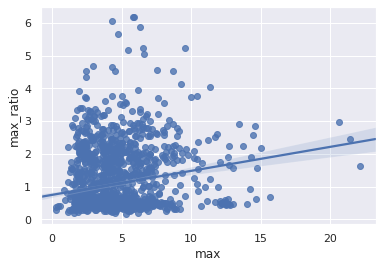

In [121]:
sns.regplot(x=nadv[nadv['opt_step'] < 200]['max'],
            y=np.log(constraints[constraints['opt_step'] < 200]['max_ratio']))

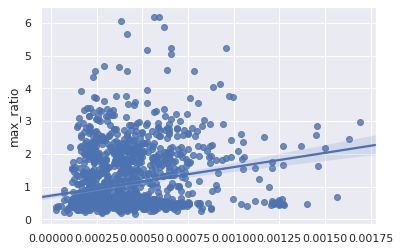

In [119]:
sns.regplot(x=nadv[nadv['opt_step'] < 200]['max'] * nadv[nadv['opt_step'] < 200]['annealed_lr'],
            y=np.log(constraints[constraints['opt_step'] < 200]['max_ratio']))

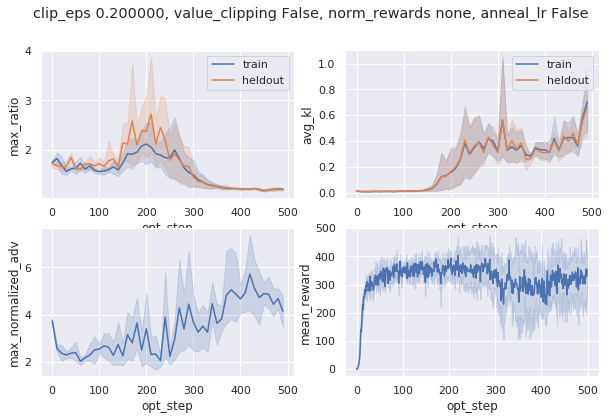

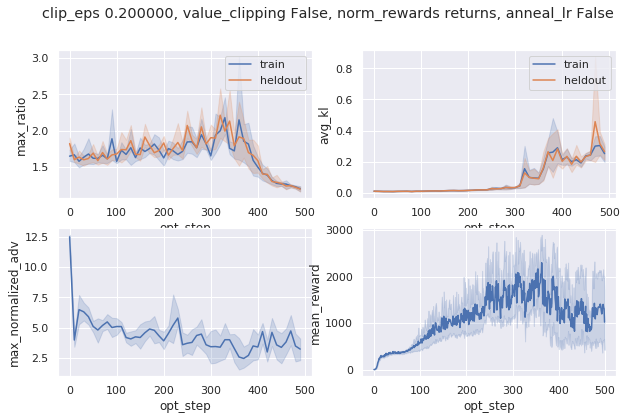

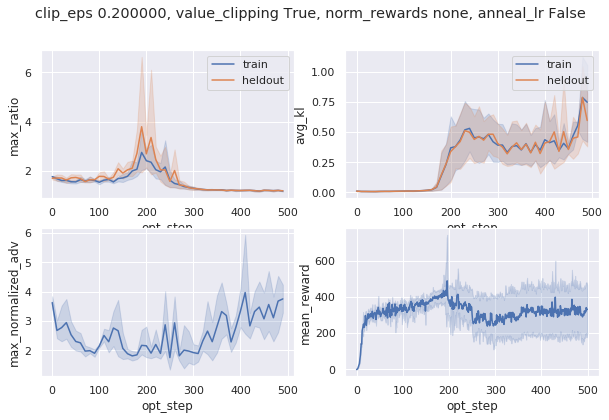

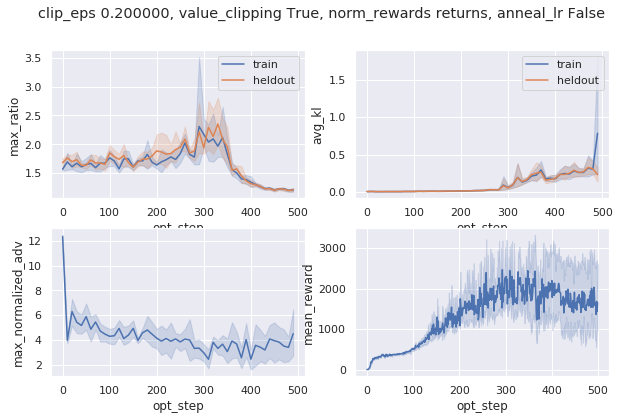

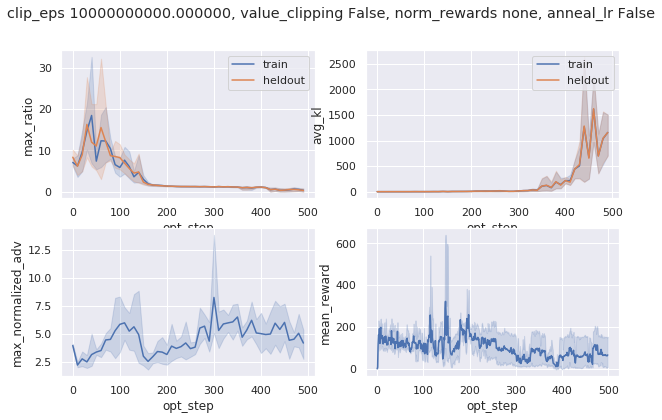

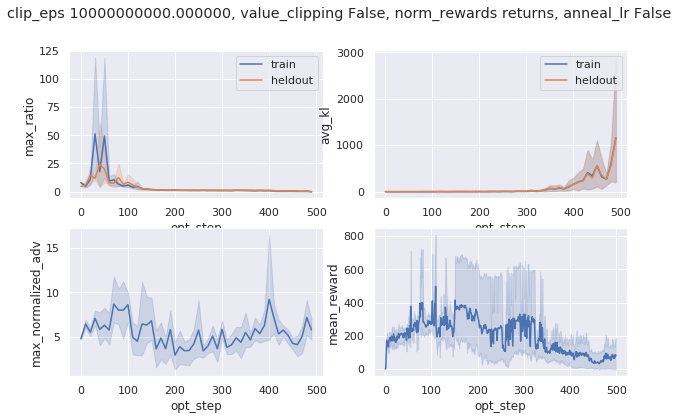

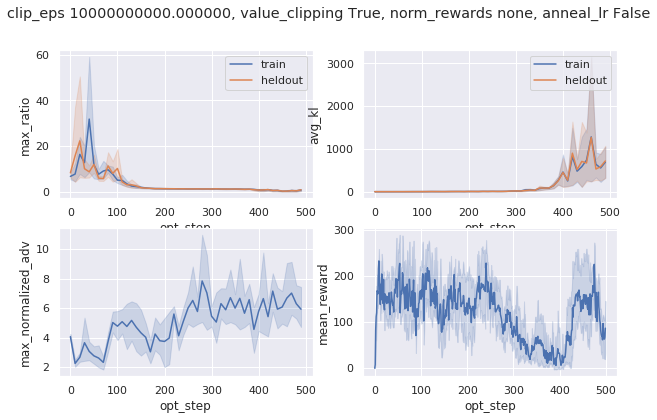

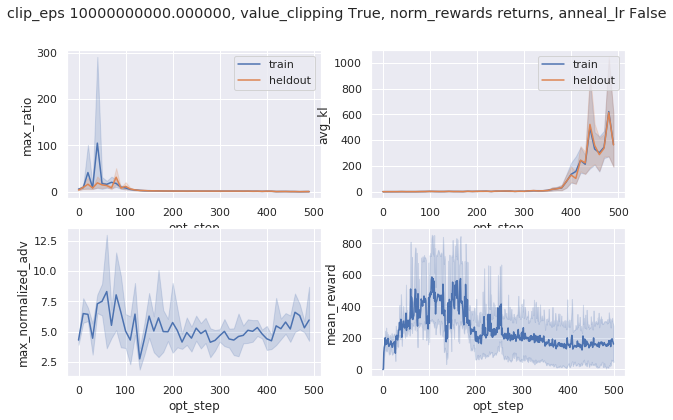

In [130]:
for i, row in exp_id_lookup.iterrows():
    if row.anneal_lr:
        continue
    title = "clip_eps %f, value_clipping %s, norm_rewards %s, anneal_lr %s" % (
        row.clip_eps, row.value_clipping, row.norm_rewards, row.anneal_lr)
    plot_stats(row.exp_id, figure_title=title)

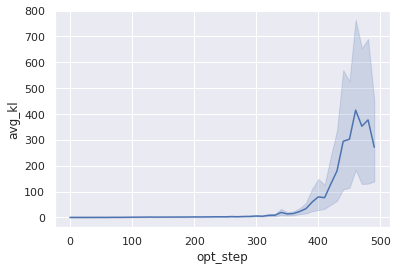

In [99]:
sns.lineplot(x=constraints['opt_step'], y=constraints['avg_kl'])

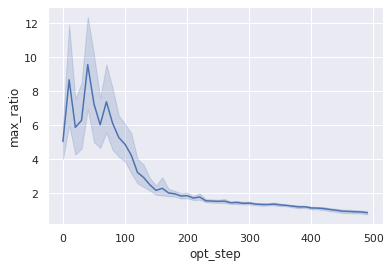

In [100]:
sns.lineplot(x=constraints['opt_step'], y=constraints['max_ratio'])

# Plot Results (using max reward)

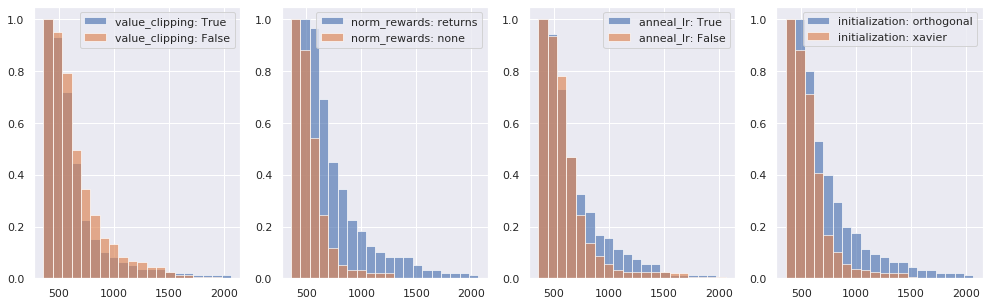

In [49]:
max_rewards = opt.groupby('exp_id').max()

# Histogram setup
_, bin_edges = np.histogram(max_rewards['mean_reward'].tolist(), NUM_BINS)
bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_ws = (bin_edges[1] - bin_edges[0])

# Plot setup
kwargs = {'width': bin_ws, 'alpha': 0.65}
fig, ax = plt.subplots(1, 4, figsize=(17,5))

for i, cl_opt in enumerate(code_level_opts):
    for b in reversed(code_level_opts[cl_opt]):
        exp_ids = set(metadata[metadata[cl_opt] == b]['exp_id'].tolist())
        filt = max_rewards[max_rewards.index.isin(exp_ids)]
        hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
        hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
        ax[i].bar(bin_locs, hist, label=f"{cl_opt}: {b}", **kwargs)
    ax[i].legend()
plt.show()

# Aggregate performance (max over learning rates, avg over trials)

In [74]:
ks = list(code_level_opts.keys())
grouped_1 = max_rewards.merge(metadata, on='exp_id').groupby(ks + ['ppo_lr_adam']).mean().reset_index().set_index('mean_reward')
grouped_2 = grouped_1.groupby(list(code_level_opts.keys())).idxmax()
grouped_2

ppo_lr_adam  \
value_clipping norm_rewards anneal_lr initialization                
False          none         False     orthogonal       513.242945   
                                      xavier           448.616458   
                            True      orthogonal       530.869896   
                                      xavier           438.276153   
               returns      False     orthogonal       710.097404   
                                      xavier           588.772932   
                            True      orthogonal       980.319935   
                                      xavier           622.461928   
True           none         False     orthogonal       488.035897   
                                      xavier           416.670703   
                            True      orthogonal       523.527723   
                                      xavier           416.366060   
               returns      False     orthogonal       649.272771   
                                      xavier           593.964707   
                            True      orthogonal       757.220427   
                                      xavier           628.480927   

                                                      final_value_loss  \
value_clipping norm_rewards anneal_lr initialization                     
False          none         False     orthogonal            513.242945   
                                      xavier                448.616458   
                            True      orthogonal           1093.424613   
                                      xavier                461.608014   
               returns      False     orthogonal            591.777176   
                                      xavier                688.112929   
                            True      orthogonal            556.167851   
                                      xavier                590.891464   
True           none         False     orthogonal            488.035897   
                                      xavier                416.670703   
                            True      orthogonal            760.434358   
                                      xavier                416.366060   
               returns      False     orthogonal            588.585160   
                                      xavier                757.605252   
                            True      orthogonal            510.167218   
                                      xavier                586.901349   

                                                        mean_std  \
value_clipping norm_rewards anneal_lr initialization               
False          none         False     orthogonal      600.091058   
                                      xavier          733.320232   
                            True      orthogonal      515.179413   
                                      xavier          547.515904   
               returns      False     orthogonal      591.777176   
                                      xavier          688.112929   
                            True      orthogonal      556.167851   
                                      xavier          590.891464   
True           none         False     orthogonal      570.957247   
                                      xavier          637.542162   
                            True      orthogonal      517.396003   
                                      xavier          531.414338   
               returns      False     orthogonal      588.585160   
                                      xavier          627.973160   
                            True      orthogonal      510.167218   
                                      xavier          586.901349   

                                                      num_minibatches  \
value_clipping norm_rewards anneal_lr initialization                    
False          none         False     orthogonal           600.091058   
                                  